# Homework 2

## Roger Garriga, Javier Mas, José Fernando Moreno

### 1. Implement the uncollapsed Gibbs sampler for latent Dirichlet allocation we discussed in class. Apply it to state-of-the-union addresses at a level of aggregation you choose and describe the output.

First, we need to set up the environment and take care of all the boring stuff (we will recycle code from the previous exercise to handle the text data)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from numpy.random import dirichlet
import scipy.sparse as ssp
from scipy.sparse import csr_matrix
import time
import topicmodels as tpm
import matplotlib.pyplot as plt


In [ ]:
path = "/home/roger/Desktop/BGSE/courses/14D010 Text Mining for Social Sciences/Text-Mining/hw1"
data = pd.read_table(path+"speech_data_extend.txt",encoding="utf-8")
data = data.loc[data['year']>=1946]
data = data.reset_index()

def data_preparation(data):
    prep_data = data.apply(lambda row: #tokenize
                            word_tokenize(row['speech'].lower()), axis=1)
    stop_w=set(stopwords.words('english')) #stopwords
    for i in range(len(prep_data)): #non-alphanumeric characters
        prep_data[i] = [w for w in prep_data[i] if w not in stop_w and w.isalpha()]
    stemmer = PorterStemmer() #Create a stemmer object
    for i in range(len(prep_data)): #Stem the data
        prep_data[i] = [stemmer.stem(elem) for elem in prep_data[i]]
    unique_words = np.unique([word for doc in prep_data for word in doc]).tolist() #List of unique words
    D = len(prep_data)
    V = len(unique_words)
    X = np.zeros((D,V)) #The document-term matrix
    N = 0
    for i in range(D):
        N = N + len(prep_data[i])
        aux_words_d = list(set(prep_data[i]))
        for j in range(len(aux_words_d)):
            X[i,unique_words.index(aux_words_d[j])] = prep_data[i].count(aux_words_d[j])
    X = csr_matrix(X.astype(int))
    return prep_data, unique_words, X, N

prep_data, unique_words, X, N = data_preparation(data)

### Sample topic allocation
First, we create a function that simulates from a multinomial and actually returns draws from a multinomial. That way, we can generate an initial guess for the Z 'matrix'.

In [ ]:
def simulate(K, row):
    samples = np.random.multinomial(1,[1/K]*K,len(prep_data[row])).tolist()
    samples_correct = []
    for s in samples:
        samples_correct.append(s.index(1))
    return samples_correct

Z = prep_data.apply(lambda row: simulate(K,row))

Note that Z is not a matrix, but a list of sublists. There are D sublists (one for each document), each one containing n_d entries (different documents have different number of words). Now, we create a function that samples from those topics

In [ ]:
def sample_topic(Z, theta, beta):
    D = len(Z)
    for d in range(D):
        n = len(Z[d])
        for i in range(n):
            beta_v = beta[unique_words.index(prep_data[d][i])]
            probs = (theta[d,:]*beta_v)/np.sum(theta[d,:]*beta_v)
            Z[d][i] = np.random.multinomial(1, probs).tolist().index(1)
    return Z

### Sample theta

For the theta, we'll need two functions: (i) a function that generates the number of counts per document and topic, and (ii) the function that actually samples from theta.

In [ ]:
def N_count(Z_d, K):
    N_count_vector = []
    for k in range(K):
        N_count_vector.append(Z_d.count(k))
    return N_count_vector

def sample_theta(Z,alpha,theta):
    D,K = theta.shape
    N = np.zeros((D,K))
    for d in range(D):
        N[d,:] = N_count(Z[d], K)
        theta[d,:] = dirichlet(N[d,:] + alpha)
    return theta


### Sample beta

Now, we will create a function that generates the betas. Note that it includes the script to generate the M, which it is needed to generate the betas.

In [ ]:
def sample_beta(Z,prep_data,eta,beta):
    K = beta.shape[1]
    M = np.zeros((K,V))
    #Generate M
    s = [i for sublist in prep_data for i in sublist ]
    z_s = [z for sublist in Z for z in sublist]
    for k in range(K):
        words = [s[i] for i in range(len(s)) if z_s[i] == k]
        counts = Counter(words)
        for v in range(len(unique_words)):
            if unique_words[v] in counts: M[k,v] = counts[unique_words[v]]
    #Generate beta
    for k in range(K):
        beta[:,k] = dirichlet(M[k,:] + eta)
    return beta

### The sampler

Finally, we put it all together inside a function, iterate and compute the perplexity

In [ ]:
def gibbs_sampler(n_iter,prep_data,alpha,eta, K, X, N, prop_perplexity):
    ## Initialize objects
    D = len(prep_data)
    theta = dirichlet([alpha]*K,D)
    beta = dirichlet([eta]*K,V)
    Z = prep_data.apply(lambda row: simulate(K,row))
    Z_dist = []
    theta_dist = []
    beta_dist = []
    perplexity = []
    for i in range(n_iter):
        print('Iteration nº:'+ str(i))
        start = time.time()
        Z = sample_topic(Z,theta,beta)
        theta = sample_theta(Z,alpha,theta)
        beta = sample_beta(Z,prep_data,eta,beta)
        if (i % (round(n_iter * prop_perplexity) + 1)) == 0:
            perplexity.append(np.exp(-np.sum(X.multiply(np.log(theta.dot(beta.T))))/N))
            np.save(path2+"perplexity.npy",perplexity)
        Z_dist.append(Z)
        theta_dist.append(theta)
        beta_dist.append(beta)
        np.save(path2+"theta.npy",theta_dist)
        np.save(path2+"Z_dist.npy",Z_dist)
        np.save(path2+"beta_dist.npy",beta_dist)
        print('Duration:'+ str(time.time()-start))
    return Z_dist, beta_dist, theta_dist, perplexity


#Initial values (reference original paper)
K = 2 #Number of topics
alpha = 50/K
V = len(unique_words)
eta = 200/V

We've tried with the parameters indicated above. Unfortunately, each iteration took 30 seconds, so we could not run a proper round. Trying with different parameters, we saw that for higher K, perplexity is lower. But it runs, so you can check it works (maybe try low number of iterations, it will show the progress in any case).

### 2. Find and run a collapsed Gibbs sampler to compare perplexity, burning-in period and the predictive distribution of theta.


In [4]:
path = "/home/roger/Desktop/BGSE/courses/14D010 Text Mining for Social Sciences/Text-Mining/hw1"
data = pd.read_table(path+"/speech_data_extend.txt", encoding="utf-8")

data = data.loc[data['year']>=1946]
data = data.reset_index()
#Tokenize

def tok_stem_data(data):
    
    prep_data = data.apply(lambda row: 
                            nltk.word_tokenize(row['speech'].lower()), axis=1)
    
    #Remove stop words and non-alphanumeric characters
    
    stop_w=set(stopwords.words('english'))
    
    
    for i in range(len(prep_data)):
        prep_data[i] = [w for w in prep_data[i] if w not in stop_w and w.isalpha()]
    
    #Stem the data
    
    stemmer = PorterStemmer() #Create a stemmer object
    
    for i in range(len(prep_data)):
        prep_data[i] = [stemmer.stem(elem) for elem in prep_data[i]]
        
    empty_str = [i for i in range(len(prep_data)) if len(prep_data[i]) == 0]        

    prep_data = prep_data.drop(empty_str)
    
    prep_data = prep_data.reset_index()
    del prep_data['index']
    prep_data.columns = ['speech']
    prep_data = pd.Series(prep_data['speech'])
    
    return prep_data

def count_words(prep_data):
    unique_words = np.unique([word for doc in prep_data for word in doc])
    unique_words = dict(zip(unique_words,range(len(unique_words))))
    D = len(prep_data)
    V = len(unique_words)
    unigram_data = [[word for word in doc] for doc in prep_data]
    X = np.zeros((D,V))
    for k in range(D):
        counts = Counter(unigram_data[k])
        for word in set(unigram_data[k]):
            X[k,unique_words[word]] = counts[word]    
    X = ssp.csr_matrix(X.astype(int))
    return X

prep_data=tok_stem_data(data)    

In [ ]:
perps = {}
K = [2,5,10,50]
for k in K:
    
    Col_Gibbs = tpm.LDA.LDAGibbs(prep_data,k)
    burn_samples = 0
    jumps = 25
    used_samples = 80

    Col_Gibbs.sample(burn_samples,jumps,used_samples)

    perp_coll = Col_Gibbs.perplexity()

    perps[str((k,Col_Gibbs.alpha,0.0241))] = perp_coll
    


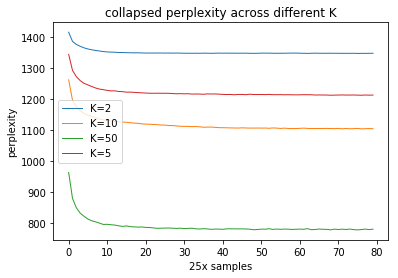

In [7]:
a = [2,10,50,5]
i = 0
for item in perps:
    plt.plot(perps[item], lw = 1., label = 'K='+str(a[i]))
    plt.legend()
    plt.ylabel('perplexity')
    plt.xlabel('25x samples')
    plt.title('collapsed perplexity across different K')
    i+=1

In [8]:
perps

{'(10, 5.0, 0.0241)': array([ 1262.40157651,  1196.24581205,  1174.55728112,  1162.04771621,
         1153.25278398,  1148.09767886,  1143.98902249,  1139.98086935,
         1135.85348159,  1132.97618549,  1131.55789479,  1129.60963851,
         1127.45466144,  1126.45643069,  1125.81221841,  1125.04355198,
         1123.46361189,  1122.51049622,  1121.70494192,  1119.9424172 ,
         1119.16378219,  1118.72275539,  1117.9351188 ,  1117.28997979,
         1116.08326786,  1116.12640594,  1114.47287815,  1114.49271448,
         1113.23866074,  1112.11783831,  1111.94666652,  1111.69395975,
         1110.92687715,  1111.31638242,  1110.46065991,  1109.05578435,
         1109.52440058,  1109.57760694,  1108.62856424,  1107.67717394,
         1107.49810845,  1107.24659273,  1106.84293412,  1106.64517063,
         1106.35633739,  1107.1499232 ,  1106.58538049,  1106.31984286,
         1106.27380132,  1106.46272317,  1106.18587472,  1106.43038843,
         1105.69500691,  1106.72593551,  11

The best perplexity is atained with 50 topics. It can be seen that with about 25x20=400 the Gibbs sampler has already reach a certain level of stability.

Similar results can be obtained with the uncollapsed Gibbs sampler. However, we could not attain stability on the perplexity, due to the computation constrain we could only do 100 iterrations.

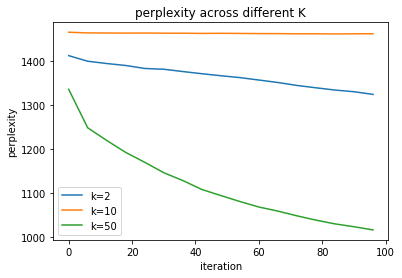

In [28]:
n_iter = 100
prop_perplexity = 0.05
count_perp = []
for i in range(n_iter):
    if (i % (round(n_iter * prop_perplexity) + 1)) == 0:
        count_perp.append(i)
count_perp = np.array(count_perp)

perp_2 = np.load("/home/roger/Desktop/BGSE/courses/14D010 Text Mining for Social Sciences/Text-Mining/results/2/perplexity.npy")
perp_10 = np.load("/home/roger/Desktop/BGSE/courses/14D010 Text Mining for Social Sciences/Text-Mining/results/10/perplexity.npy")
perp_50 = np.load("/home/roger/Desktop/BGSE/courses/14D010 Text Mining for Social Sciences/Text-Mining/results/50/perplexity.npy")

d = {'k=2': perp_2, 'k=10': perp_10, 'k=50': perp_50}
index = count_perp.tolist()
df = pd.DataFrame(data = d, index = index)

plt.plot(df)
plt.ylabel('perplexity')
plt.xlabel('iteration')
plt.title('uncollapsed perplexity across different K')
plt.legend(["k=2", "k=10", "k=50"])
plt.show()

Now we will analyse the estimated theta across the samples after the burn in period. 

In [ ]:
K = 50

Col_Gibbs = tpm.LDA.LDAGibbs(prep_data,K)
alpha =  Col_Gibbs.alpha

burn_samples = 800
jumps = 25
used_samples = 50

Col_Gibbs.sample(burn_samples,jumps,used_samples)

In [10]:
K = 50
alpha =  Col_Gibbs.alpha
perp_coll = Col_Gibbs.perplexity()
doc_topics = Col_Gibbs.dt_avg()

Nd = np.array([len(par) for par in prep_data])
Nd = Nd.reshape((len(prep_data),1))
Ndtop = np.array(Nd*doc_topics)

In [11]:
theta_coll = (Ndtop+alpha)/(Nd+K*alpha)
theta_coll =  pd.DataFrame(theta_coll)

mean_coll = np.array(theta_coll.mean(axis=0))
var_coll = np.array(np.var(theta_coll, axis=0))

theta_2 = np.load("/home/roger/Desktop/BGSE/courses/14D010 Text Mining for Social Sciences/Text-Mining/results/2/theta.npy")
theta_10 = np.load("/home/roger/Desktop/BGSE/courses/14D010 Text Mining for Social Sciences/Text-Mining/results/10/theta.npy")
theta_50 = np.load("/home/roger/Desktop/BGSE/courses/14D010 Text Mining for Social Sciences/Text-Mining/results/50/theta.npy")


mean_uncoll = np.average(np.array(theta_50), axis=0).mean(axis=0)
var_uncoll = np.average(np.array(theta_50), axis=0).var(axis=0)

table_coll = pd.DataFrame(np.vstack((mean_coll,mean_uncoll, var_coll, var_uncoll)).T)
table_coll.columns = ['mean_coll','mean_uncoll','var_coll','var_uncoll']
table_coll



,mean_coll,mean_uncoll,var_coll,var_uncoll
0,0.019788,0.019489,0.000016,0.000389
1,0.019847,0.019978,0.000018,0.000391
2,0.019963,0.019731,0.000054,0.000456
3,0.019954,0.019852,0.000021,0.000412
4,0.020058,0.019722,0.000031,0.000447
5,0.020319,0.020279,0.000094,0.000448
6,0.020003,0.020028,0.000069,0.000400
7,0.019777,0.020130,0.000021,0.000446
8,0.019887,0.020371,0.000031,0.000429
9,0.020088,0.020723,0.000053,0.000492


This shows that all the topics appear with the same frequency approximately (the mean is similar). There are some topics that have more variation than others, but the difference is not big. However, there is 10 times more variance on the uncollapsed than in the collapsed, what would mean that the topics are assigned with more probability to each document.

### 3. Now focus on individual paragraphs of state-of-the-union addresses from 1946 on- wards in which every paragraph is associated with one of two political parties.

Again, let's set up the environment and load everything that is needed.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def tok_stem_data(data):
    
    prep_data = data.apply(lambda row: 
                            nltk.word_tokenize(row['speech'].lower()), axis=1)
    
    #Remove stop words and non-alphanumeric characters
    
    stop_w=set(stopwords.words('english'))
    
    
    for i in range(len(prep_data)):
        prep_data[i] = [w for w in prep_data[i] if w not in stop_w and w.isalpha()]
    
    #Stem the data
    
    stemmer = PorterStemmer() #Create a stemmer object
    
    for i in range(len(prep_data)):
        prep_data[i] = [stemmer.stem(elem) for elem in prep_data[i]]
        
    #empty_str = [i for i in range(len(prep_data)) if len(prep_data[i]) == 0]        

    #prep_data = prep_data.drop(empty_str)
    
    #prep_data = prep_data.reset_index()
    #del prep_data['index']
    #prep_data.columns = ['speech']
    #prep_data = pd.Series(prep_data['speech'])
    
    return prep_data


prep_data=tok_stem_data(data)

# Select only documents which appear after 1946
X = count_words(prep_data)
# Create a new variable with only presidents and years
parties = data.loc[:,['president', 'year']]
parties = parties.reset_index()
# Create a new variable with 1 when presidents are Democrats, 0 when they are Republicans
zero_len = pd.Series(np.zeros(len(parties.index)))
parties['parties'] = zero_len
parties['parties'] = (parties.president == "Truman") | (parties.president == "Kennedy") | (parties.president == "Johnson") | (parties.president == "Carter") | (parties.president == "Clinton") | (parties.president == "Obama")
parties.parties = list(map(lambda x: 1 if x else 0, parties.parties))
parties = parties.iloc[:][parties.year >= 1946]
# Set the parties variable as y
y = parties.parties
# Split the X and y variables into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Now, let's start with the fun stuff. First, we first a logistic regression model and do some basic parameter tuning.

In [13]:
# Create the logistic regression estimator with an l1 loss parameter
log_reg = LogisticRegression(penalty = "l1")
# Set some parameters to tune over
c_space = [1.3, 1.5, 1.7]
parameters = {'C': c_space}
# Create a cross-validation estimator
cv = GridSearchCV(log_reg, parameters)
# Fit the model, predict and report the accuracy and the best parameter
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.6682227409136379
             precision    recall  f1-score   support

          0       0.66      0.68      0.67      1469
          1       0.68      0.66      0.67      1530

avg / total       0.67      0.67      0.67      2999

Tuned Model Parameters: {'C': 1.5}


Now, we'll try with a logistic regression using the topics instead of the document-term matrix

In [ ]:
X = count_words(prep_data)
K = 2
Col_Gibbs = tpm.LDA.LDAGibbs(prep_data,k)
burn_samples = 800
jumps = 25
used_samples = 50
Col_Gibbs.sample(burn_samples,jumps,used_samples)


In [15]:
X = Col_Gibbs.dt_avg()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 59)
log_reg = LogisticRegression("l2")
c_space = [0.5, 2, 5]
parameters = {'C': c_space}
# Create a cross-validation estimator
cv = GridSearchCV(log_reg, parameters)
# Fit the model, predict and report the accuracy and the best parameter
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.6268756252084028
             precision    recall  f1-score   support

          0       0.64      0.58      0.61      1491
          1       0.62      0.67      0.65      1508

avg / total       0.63      0.63      0.63      2999

Tuned Model Parameters: {'C': 5}
